<a href="https://colab.research.google.com/github/vknalluri/64061/blob/main/Sentiment_Transformers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Loading the data - dataset is .tsv(tab seperated values) file , hence we need to specify the delimiter.

In [13]:
import pandas as pd

df = pd.read_csv('train.tsv', sep='\t')
#df = df.iloc[:100000,:].values
#df = df.sample(frac=0.3,random_state=200)

df.head()
#df.info()


,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2


Phrase column contains actual entries that are duplicated (sentence id shows the duplicates. We can remove the duplicates , reducing the values in the data set, however, we will not remove them as we need large dataset.

In [14]:
df = df.drop_duplicates(subset=['SentenceId'], keep='first')

df.head()

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
63,64,2,"This quiet , introspective and entertaining in...",4
81,82,3,"Even fans of Ismail Merchant 's work , I suspe...",1
116,117,4,A positively thrilling combination of ethnogra...,3
156,157,5,Aggressive self-glorification and a manipulati...,1


There are 5 lables(0 to 4), represented by sentiment id. Lets check the distribution

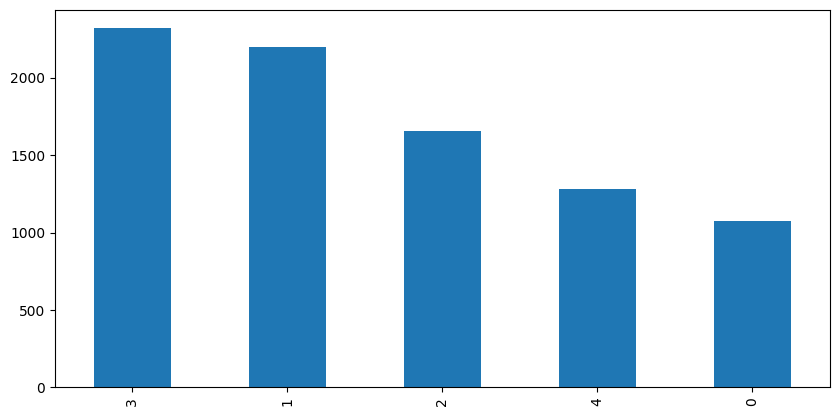

In [15]:

import matplotlib.pyplot as plt
plt.figure(figsize=(10,5), dpi=100)

df['Sentiment'].value_counts().plot(kind='bar')

Lets begin to tokenize the text to create two input tensors; input ids and attention mask using seq_len of 512 (BERT the transfer learning transformer that we are going to rely later uses a sequence length of 512, hence we maintain the same)

In [16]:
import numpy as np

seq_len = 512
num_samples = len(df)

num_samples, seq_len

(8529, 512)

Lets tokenize based on Bert-base-cased model...

In [17]:
#!pip install transformers
from transformers import BertTokenizer

# initialize tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
tokens = tokenizer(df['Phrase'].tolist(), max_length=seq_len, truncation=True,
                   padding='max_length', add_special_tokens=True,
                   return_tensors='np')

Downloading:   0%|          | 0.00/208k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Lets check for the keys in the tokens

In [18]:
tokens.keys()


dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])

Lets check the contents of one of the keys (input_ids)

In [19]:
tokens['input_ids'][:10]


array([[ 101,  138, 1326, ...,    0,    0,    0],
       [ 101, 1188, 3589, ...,    0,    0,    0],
       [ 101, 2431, 3899, ...,    0,    0,    0],
       ...,
       [ 101, 1109,  146, ...,    0,    0,    0],
       [ 101, 1252, 1122, ...,    0,    0,    0],
       [ 101, 1192, 1180, ...,    0,    0,    0]])

Lets save the keys

In [20]:
with open('movie-xids.npy', 'wb') as f:
    np.save(f, tokens['input_ids'])
with open('movie-xmask.npy', 'wb') as f:
    np.save(f, tokens['attention_mask'])
  

In [21]:
  del tokens

Lets extract our target variable (Sentiment) and one hot encode them as the values are in integer form and save the labels.

In [22]:
arr = df['Sentiment'].values
labels = np.zeros((num_samples, arr.max()+1)) # arr.max will be 4 but arr size is 5. To accommodate another we will create a zero array with 5 elements
labels.shape
labels[np.arange(num_samples), arr] = 1

with open('movie-labels.npy', 'wb') as f:
    np.save(f, labels)

labels

array([[0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       ...,
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.]])

Lets Create TensorFlow InputPipeLine using tf.data API to create data for batch processing:

Lets first load the binaries that are saved to the session.

In [23]:
import numpy as np

with open('movie-xids.npy', 'rb') as f:
    Xids = np.load(f, allow_pickle=True)
with open('movie-xmask.npy', 'rb') as f:
    Xmask = np.load(f, allow_pickle=True)
with open('movie-labels.npy', 'rb') as f:
    labels = np.load(f, allow_pickle=True)

    import tensorflow as tf

dataset = tf.data.Dataset.from_tensor_slices((Xids, Xmask, labels)) #Create the dataset from the three arrays

dataset.take(1)

<TakeDataset element_spec=(TensorSpec(shape=(512,), dtype=tf.int64, name=None), TensorSpec(shape=(512,), dtype=tf.int64, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

We have three tensor but model accepts one two:input and output. Hence, lets create a dictionary of two tensors (inputs and output)

In [24]:
def map_func(input_ids, masks, labels):
    # we convert our three-item tuple into a two-item tuple where the input item is a dictionary
    return {'input_ids': input_ids, 'attention_mask': masks}, labels

# then we use the dataset map method to apply this transformation
dataset = dataset.map(map_func)

dataset.take(1)

<TakeDataset element_spec=({'input_ids': TensorSpec(shape=(512,), dtype=tf.int64, name=None), 'attention_mask': TensorSpec(shape=(512,), dtype=tf.int64, name=None)}, TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

We will shuffle and batch the dataset. we will also drop those that dont fit into the chunks of 16.

In [25]:
batch_size = 16

dataset = dataset.shuffle(10000).batch(batch_size, drop_remainder=True)

dataset.take(1)

<TakeDataset element_spec=({'input_ids': TensorSpec(shape=(16, 512), dtype=tf.int64, name=None), 'attention_mask': TensorSpec(shape=(16, 512), dtype=tf.int64, name=None)}, TensorSpec(shape=(16, 5), dtype=tf.float64, name=None))>

Lets find the split size

In [26]:
split = 0.9

# we need to calculate how many batches must be taken to create 90% training set
size = int((Xids.shape[0] / batch_size) * split)

size

479

Split the dataset

In [27]:
train_ds = dataset.take(size)
val_ds = dataset.skip(size)

# free up memory
del dataset

Save the train and validation sets

In [28]:
tf.data.experimental.save(train_ds, 'train')
tf.data.experimental.save(val_ds, 'val')

tf.data.experimental.load that requires to define the tensor element_spec - which describes the tensor shape.

In [29]:
train_ds.element_spec


({'attention_mask': TensorSpec(shape=(16, 512), dtype=tf.int64, name=None),
  'input_ids': TensorSpec(shape=(16, 512), dtype=tf.int64, name=None)},
 TensorSpec(shape=(16, 5), dtype=tf.float64, name=None))

In [30]:
val_ds.element_spec == train_ds.element_spec

True

Now lets build our classifier. we will build our classifier around BERT.Lets initialize BERT from the pretrained bert-base-cased

In [31]:
from transformers import TFAutoModel

bert = TFAutoModel.from_pretrained('bert-base-cased')

# we can view the model using the summary method
bert.summary()

Downloading:   0%|          | 0.00/502M [00:00<?, ?B/s]

Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Model: "tf_bert_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  108310272 
                                                                 
Total params: 108,310,272
Trainable params: 108,310,272
Non-trainable params: 0
_________________________________________________________________


Now we need to define the frame around Bert, we need:

Two input layers (one for input IDs and one for attention mask).

A post-bert dropout layer to reduce the likelihood of overfitting and improve generalization.

Max pooling layer to convert the 3D tensors output by Bert to 2D.

Final output activations using softmax for outputting categorical probabilities.

In [32]:
import tensorflow as tf

# two input layers, we ensure layer name variables match to dictionary keys in TF dataset
input_ids = tf.keras.layers.Input(shape=(512,), name='input_ids', dtype='int32')
mask = tf.keras.layers.Input(shape=(512,), name='attention_mask', dtype='int32')

# we access the transformer model within our bert object using the bert attribute (eg bert.bert instead of bert)
embeddings = bert.bert(input_ids, attention_mask=mask)[1]  # access final activations (alread max-pooled) [1]
# convert bert embeddings into 5 output classes
x = tf.keras.layers.Dense(1024, activation='relu')(embeddings)
y = tf.keras.layers.Dense(5, activation='softmax', name='outputs')(x)

Lets build our final model. We can freeze BERT as its already pretrained to avoide longer unnecessary training times.


In [33]:
# initialize model
model = tf.keras.Model(inputs=[input_ids, mask], outputs=y)

# freeze bert layer
model.layers[2].trainable = False

# print out model summary
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 512)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 512)]        0           []                               
                                                                                                  
 bert (TFBertMainLayer)         TFBaseModelOutputWi  108310272   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_mask[0][0]']         
                                tentions(last_hidde                                               
                                n_state=(None, 512,                                           

Lets initialize the training parameters and compile.

In [43]:
optimizer = tf.keras.optimizers.Adam(lr=1e-5, decay=1e-6)
#optimizer = tf.keras.optimizers.Adam(lr=0.01, decay=0.01)

loss = tf.keras.losses.CategoricalCrossentropy()
acc = tf.keras.metrics.CategoricalAccuracy('accuracy')

model.compile(optimizer=optimizer, loss=loss, metrics=[acc])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Lets load the train and validation sets that are saved earlier.

In [44]:
element_spec = ({'input_ids': tf.TensorSpec(shape=(16, 512), dtype=tf.int64, name=None),
                 'attention_mask': tf.TensorSpec(shape=(16, 512), dtype=tf.int64, name=None)},
                tf.TensorSpec(shape=(16, 5), dtype=tf.float64, name=None))

# load the training and validation sets
train_ds = tf.data.experimental.load('train', element_spec=element_spec)
val_ds = tf.data.experimental.load('val', element_spec=element_spec)

# view the input format
train_ds.take(1)
val_ds.take(1)

<TakeDataset element_spec=({'input_ids': TensorSpec(shape=(16, 512), dtype=tf.int64, name=None), 'attention_mask': TensorSpec(shape=(16, 512), dtype=tf.int64, name=None)}, TensorSpec(shape=(16, 5), dtype=tf.float64, name=None))>

Lets train the model with 2 epochs.

In [45]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=2
)

Epoch 1/2
479/479 [==============================] - 2402s 5s/step - loss: 3.5497 - accuracy: 0.2123 - val_loss: 1.9913 - val_accuracy: 0.2940
Epoch 2/2
479/479 [==============================] - 2322s 5s/step - loss: 1.7071 - accuracy: 0.2854 - val_loss: 1.5268 - val_accuracy: 0.3218


Save the model.

In [46]:
model.save('sentiment_model')

INFO:tensorflow:Assets written to: sentiment_model/assets


INFO:tensorflow:Assets written to: sentiment_model/assets


Load the saved model....

In [47]:
import tensorflow as tf

model = tf.keras.models.load_model('sentiment_model')

# view model architecture to confirm we have save and loaded correctly
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 512)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 512)]        0           []                               
                                                                                                  
 bert (TFBertMainLayer)         TFBaseModelOutputWi  108310272   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_mask[0][0]']         
                                tentions(last_hidde                                               
                                n_state=(None, 512,                                           

Before making predictions we need to format the data and requires two steps:

Tokenizing the data using the bert-base-cased tokenizer.

Transforming the data into a dictionary containing 'input_ids' and 'attention_mask' tensors.


In [48]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

def prep_data(text):
    tokens = tokenizer.encode_plus(text, max_length=512,
                                   truncation=True, padding='max_length',
                                   add_special_tokens=True, return_token_type_ids=False,
                                   return_tensors='tf')
    # tokenizer returns int32 tensors, we need to return float64, so we use tf.cast
    return {'input_ids': tf.cast(tokens['input_ids'], tf.float64),
            'attention_mask': tf.cast(tokens['attention_mask'], tf.float64)}

Lets predict on saple data


In [49]:
probs = model.predict(prep_data("hello world"))[0]

probs

array([0.08886567, 0.26245874, 0.16897109, 0.3189029 , 0.16080166],
      dtype=float32)

So we have made a test prediction, but we want to be applying this to real phrases from test.tsv. We will load the data into a dataframe, remove fragment duplicates based on SentenceId, then iterate through the list and create a new sentiment column.

In [50]:
import pandas as pd

# so we can see full phrase
pd.set_option('display.max_colwidth', None)

df = pd.read_csv('test.tsv', sep='\t')
df.head()
df = df.drop_duplicates(subset=['SentenceId'], keep='first')
df.head()

,PhraseId,SentenceId,Phrase
0,156061,8545,An intermittently pleasing but mostly routine effort .
15,156076,8546,"Kidman is really the only thing that 's worth watching in Birthday Girl , a film by the stage-trained Jez Butterworth -LRB- Mojo -RRB- that serves as yet another example of the sad decline of British comedies in the post-Full Monty world ."
93,156154,8547,Once you get into its rhythm ... the movie becomes a heady experience .
117,156178,8548,I kept wishing I was watching a documentary about the wartime Navajos and what they accomplished instead of all this specious Hollywood hoo-ha .
158,156219,8549,"Kinnear does n't aim for our sympathy , but rather delivers a performance of striking skill and depth ."


Now we initialize our new sentiment column, and begin making predictions.

In [51]:
df['Sentiment'] = None

for i, row in df.iterrows():
    # get token tensors
    tokens = prep_data(row['Phrase'])
    # get probabilities
    probs = model.predict(tokens)
    # find argmax for winning class
    pred = np.argmax(probs)
    # add to dataframe
    df.at[i, 'Sentiment'] = pred

df.head()

,PhraseId,SentenceId,Phrase,Sentiment
0,156061,8545,An intermittently pleasing but mostly routine effort .,1
15,156076,8546,"Kidman is really the only thing that 's worth watching in Birthday Girl , a film by the stage-trained Jez Butterworth -LRB- Mojo -RRB- that serves as yet another example of the sad decline of British comedies in the post-Full Monty world .",3
93,156154,8547,Once you get into its rhythm ... the movie becomes a heady experience .,3
117,156178,8548,I kept wishing I was watching a documentary about the wartime Navajos and what they accomplished instead of all this specious Hollywood hoo-ha .,1
158,156219,8549,"Kinnear does n't aim for our sympathy , but rather delivers a performance of striking skill and depth .",3


In [52]:
df.tail()

,PhraseId,SentenceId,Phrase,Sentiment
66220,222281,11851,Not sweet enough to liven up its predictable story and will leave even fans of hip-hop sorely disappointed .,3
66239,222300,11852,"Nasty , ugly , pointless and depressing , even if you hate clowns .",1
66253,222314,11853,"With tightly organized efficiency , numerous flashbacks and a constant edge of tension , Miller 's film is one of 2002 's involvingly adult surprises .",3
66280,222341,11854,They should have called it Gutterball .,1
66287,222348,11855,"A long-winded , predictable scenario .",1


In [60]:
probs = model.predict(prep_data("its cool"))[0]

probs


np.argmax(probs)

3

In [57]:
probs = model.predict(prep_data("not that good"))[0]

probs

np.argmax(probs)

1

In [61]:
probs = model.predict(prep_data("ok"))[0]

probs


np.argmax(probs)

3

In [62]:
probs = model.predict(prep_data("it was lovely but would have been too good had it been more adventurous"))[0]

probs


np.argmax(probs)

1